In [ ]:
#client
import sys
import socket
import time
import threading
import random
import numpy as np
from tqdm import tqdm

#define
HOST="127.0.0.1"
SERVER_RECEIVE_PORT=50000 #服务端接收报文
SERVER_ACK_PORT=50001 #服务端发送ACK 非必须
CLIENT_SEND_PORT=50002 #客户端发送报文 非必须
CLIENT_ACK_PORT=50003 #客户端接收ACK
MAX_DATA_LENGTH=4194304 #最大报文长度4M
SSTHRESH=16 #拥塞窗口阈值
SWND=2 #初始发送窗口
TIMEOUT=2 #超时重传时间

def msg_sender(msg_array,ack_array):
    #信息发送套接字
    m_sender=socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    m_sender.bind((HOST,CLIENT_SEND_PORT))

    time_array=np.zeros_like(msg_array,dtype=float)
    segment_p=0
    swnd_p=0
    with tqdm(total=len(msg_array)) as pbar:
        while(True):
            if(segment_p==len(msg_array)):#发送完成
                pbar.update(SWND)
                m_sender.close()
                break
            while ack_array[swnd_p]:#移动窗口
                swnd_p+=1
                pbar.update()
            if segment_p==swnd_p+SWND:
                for _ in range(segment_p-SWND,segment_p):
                    if ack_array[_]==False and time.perf_counter()-time_array[_]>TIMEOUT:
                        m_sender.sendto(str(msg_array[_]).encode("utf8"),(HOST,SERVER_RECEIVE_PORT))
                continue
            m_sender.sendto(str(msg_array[segment_p]).encode("utf8"),(HOST,SERVER_RECEIVE_PORT))
            time_array[segment_p]=time.perf_counter()
            segment_p+=1


def ack_receiver(ack_array):
    #ack接收套接字
    ack_receiver=socket.socket(socket.AF_INET,socket.SOCK_DGRAM)
    ack_receiver.bind((HOST,CLIENT_ACK_PORT))
    ack_receiver.settimeout(2*TIMEOUT)
    while(True):
        ack,addr=ack_receiver.recvfrom(1024)
        if ack:
            ack=int(ack.decode("utf8"))
            ack_array[ack]=True

class senderThread(threading.Thread):
    def __init__(self,msg_array,ack_array):
        threading.Thread.__init__(self)
        self.msg_array=msg_array
        self.ack_array=ack_array
    def run(self):
        msg_sender(self.msg_array,self.ack_array)

class receiverThread(threading.Thread):
    def __init__(self,ack_array):
        threading.Thread.__init__(self)
        self.ack_array=ack_array
    def run(self):
        ack_receiver(self.ack_array)


if __name__=="__main__":
    msg_length=4096
    massage=np.zeros([msg_length],dtype=int)
    for _ in range(len(massage)):
        massage[_]=_
    ack=np.zeros([msg_length],dtype=bool)
    #print(massage.shape,ack.shape)
    thread1=senderThread(massage,ack)
    thread2=receiverThread(ack)
    thread1.start()
    thread2.start()

In [ ]:
#server
import socket
import threading
import queue
import time
from random import random


#define
HOST="127.0.0.1"
SERVER_RECEIVE_PORT=50000 #服务端接收报文
SERVER_ACK_PORT=50001 #服务端发送ACK
CLIENT_SEND_PORT=50002 #客户端发送报文
CLIENT_ACK_PORT=50003 #客户端接收ACK
MAX_DATA_LENGTH=4194304 #最大报文长度4M
SWND=8 #发送窗口
TIMEOUT=2 #超时重传时间

def msg_receiver(rec_queue,p_drop):
    #接收发送端报文，存入rec_array，以概率p_drop丢包
    rec_socket=socket.socket(socket.AF_INET,socket.SOCK_DGRAM)
    rec_socket.bind((HOST,SERVER_RECEIVE_PORT))
    rec_socket.settimeout(2*TIMEOUT)
    round_start=time.perf_counter()
    pkg_num=0
    while(True):
        round_end=time.perf_counter()
        if round_end-round_start>=1:
            print("speed:{}/s".format(pkg_num))
            pkg_num=0
            round_start=round_end
        msg,addr=rec_socket.recvfrom(1024)
        #print(msg.decode("utf8"),addr)
        msg=msg.decode("utf8")
        if msg:
            if random()>p_drop and not rec_queue.full():
                rec_queue.put(msg)
                pkg_num+=1
            continue

def ack_sender(rec_queue):
    #回复ack信息，线程间通过队列通信
    ack_socket=socket.socket(socket.AF_INET,socket.SOCK_DGRAM)
    ack_socket.bind((HOST,SERVER_ACK_PORT))
    wc_dog=time.perf_counter()
    while(True):
        if not rec_queue.empty():
            ack=str(rec_queue.get()).encode("utf8")
            ack_socket.sendto(ack,(HOST,CLIENT_ACK_PORT))
            wc_dog=time.perf_counter()
            continue
        if time.perf_counter()-wc_dog>2*TIMEOUT:
            ack_socket.close()
            print("ACK TIMEOUT CLOSE")
            break


class msgrecThread(threading.Thread):
    def __init__(self,rec_queue,p_drop):
        threading.Thread.__init__(self)
        self.rec_queue=rec_queue
        self.p_drop=p_drop
    def run(self):
        msg_receiver(self.rec_queue,self.p_drop)

class acksendThread(threading.Thread):
    def __init__(self,rec_queue):
        threading.Thread.__init__(self)
        self.rec_queue=rec_queue
    def run(self):
        ack_sender(self.rec_queue)


if __name__=="__main__":
    msg_queue=queue.Queue(MAX_DATA_LENGTH)
    thread1=msgrecThread(msg_queue,0.03)
    thread2=acksendThread(msg_queue)
    thread1.start()
    thread2.start()

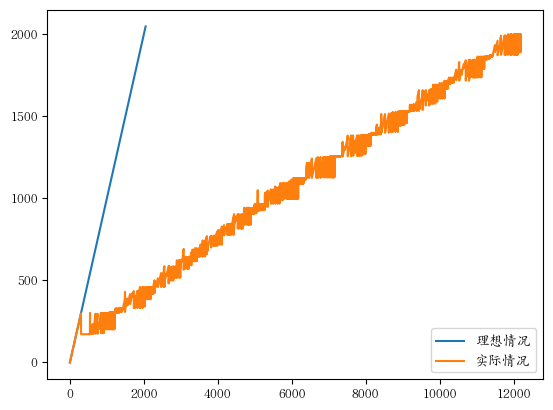

效率: 0.16422071001065836


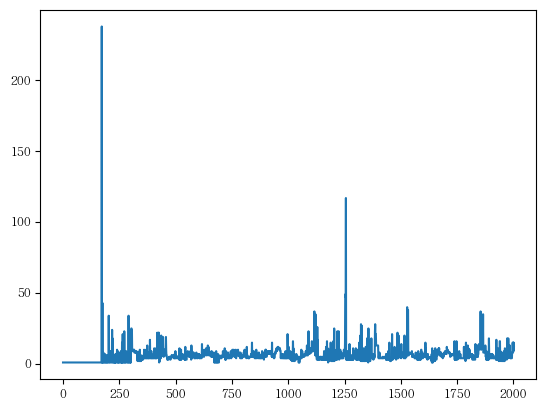

51.247899159663866


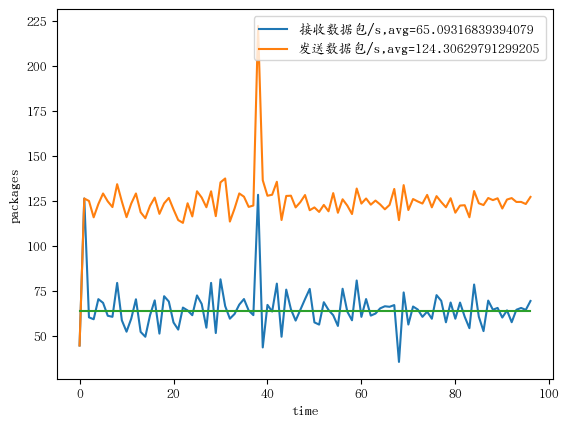

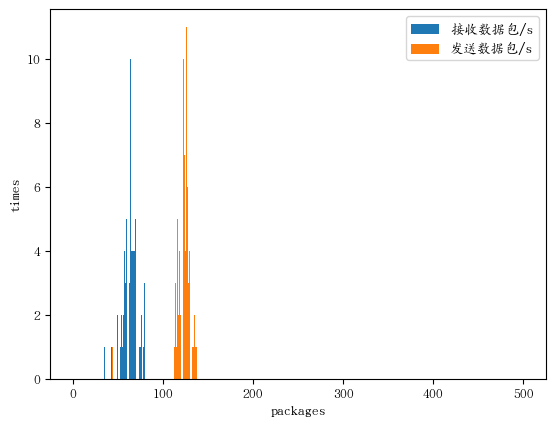

In [28]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pywt

plt.rcParams['font.family'] = 'AR PL UKai CN'  # 替换为你选择的字体

result="./works/result.log"

def pkg_every_moment(result):
    pkgs=[]
    with open(result,"r") as f:
        for _ in f:
            if _.endswith("('127.0.0.1', 50002)\n"):
                pkgs.append(int(_.split()[0]))

    pkg_seq=np.array(pkgs)
    pkgs.sort()
    pkg_length=pkgs[-1]+1
    plt.plot([0,2048],[0,2048])
    plt.plot(pkg_seq)
    plt.legend(["理想情况","实际情况"])
    plt.show()# 每时间发送报文序列
    print("效率:",pkg_length/len(pkgs))#发送效率
    pkg_list=np.zeros([pkg_length],dtype=int)
    for _ in pkgs:
        pkg_list[_]+=1
    plt.plot(range(pkg_length),(pkg_list))
    plt.show()#每份报文发送次数
    print(len(pkgs)/np.max(pkg_list))#平均发送次数

def barize(array):
    max=500#np.max(array)
    seq=np.zeros([max+1],dtype=int)
    for _ in array:
        if _<500:
            seq[_]+=1
    return seq

def speed_every_moment(result,bar=False):
    speed_got=[]
    speed_recv=[]
    with open(result,"r") as f:
        for _ in f:
            if _.endswith("seconds\n"):
                spl=_.split()
                speed_got.append(float(spl[1]))
                speed_recv.append(float(spl[3]))    
    
    bw=[64]*len(speed_got)
    plt.xlabel("time")
    plt.ylabel("packages")
    plt.plot(speed_got)
    plt.plot(speed_recv)
    plt.legend(["接收数据包/s,avg={}".format(np.mean(speed_got)),"发送数据包/s,avg={}".format(np.mean(speed_recv))])
    plt.plot(bw)
    plt.show()#发送速度和接收速度
    if bar:
        intger=np.vectorize(lambda x:int(x))
        speed_got=intger(speed_got)
        speed_recv=intger(speed_recv)
        speed_got=barize(speed_got)
        speed_recv=barize(speed_recv)
        plt.xlabel("packages")
        plt.ylabel("times")
        plt.bar(range(len(speed_got)),speed_got)
        plt.bar(range(len(speed_recv)),speed_recv)
        plt.legend(["接收数据包/s","发送数据包/s"])
        plt.show()

def xiaobo(result):
    #二维时频图
    #1.2.3为参数，y为参数
    sr=128 #1.sampling rate
    wavename = 'morl'#2.母小波名称
    totalscal = 150 # 3.totalscal是对信号进行小波变换时所用尺度序列的长度(通常需要预先设定好)
    fc = pywt.central_frequency(wavename)  # 计算小波函数的中心频率
    cparam = 2 * fc * totalscal  # 常数c
    scales = cparam / np.arange(totalscal, 1, -1)  # 为使转换后的频率序列是一等差序列，尺度序列必须取为这一形式（也即小波尺度）
    y=[]#y=pkg_list
    [cwtmatr, frequencies] = pywt.cwt(y, scales, wavename, 1.0 / sr)#4.y为将要进行cwt变换的一维输入信号
    t = np.arange(0, y.shape[0]/sr, 1.0/sr)
    plt.contourf(t, frequencies, abs(cwtmatr))
    plt.ylabel(u"freq(Hz)")
    plt.xlabel(u"time(s)")
    # plt.subplots_adjust(hspace=0.4)  # 调整边距和子图的间距 hspace为子图之间的空间保留的高度，平均轴高度的一部分
    plt.show()


pkg_every_moment(result)
speed_every_moment(result,True)

In [ ]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt


x=np.linspace(-10,10,1024)
y=np.linspace(-10,10,1024)
x,y=np.meshgrid(x,y)
z_1=np.sqrt(x**2+y**2)
z_2=-np.sqrt(x**2+y**2)

fig=plt.figure()
ax=plt.axes(projection="3d")
ax.contour3D(x,y,z_1,50)
ax.contour3D(x,y,z_2,50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(30,35)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def is_odd(n):
    return n%2==1

def collatz(n):
    array=[]
    while n!=1:
        array.append(n)
        if is_odd(n):
            n=3*n+1
        else:
            n=n/2
    array.append(n)
    return np.array(array)

plt.plot(collatz(27))
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
def mandelbrot(h,w,maxit=64):
    y,x = np.ogrid[-1.4:1.4:h*1j,-2:0.8:w*1j]
    c = x+y*1j
    z = c 
    divtime = maxit + np.zeros(z.shape,dtype=int)
    for i in range(maxit):
        z = z**2 +c
        diverge = z*np.conj(z) > 2**2
        div_now = diverge & (divtime==maxit)
        divtime[div_now] = i 
        z[diverge] = 2 
    return divtime
 
plt.imshow(mandelbrot(500,500))
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random

device_num=100
time=10000
miu=5
sigma=1
def speed_sum(device_num,miu,sigma):
    speed=random.normal(miu,sigma,device_num)
    speed=[max(0,_) for _ in speed]
    return np.sum(speed)

probability=[]
for i in range(1,miu+1):
    probability.append(np.zeros([device_num],dtype=float))

for k in range(1,miu+1):
    for i in range(1,device_num+1):
        count=0
        for j in range(time):
            if speed_sum(i,k,sigma)>100:
                count+=1
        probability[k-1][i-1]=count/time


plt.xlabel("device_num")
plt.ylabel("probability")
legend=["miu={}".format(i) for i in range(1,miu+1)]
for i in range(miu):
    plt.plot(range(1,device_num+1),probability[i])
plt.legend(legend)
for i in range(miu):
    plt.axvline(x=100/(i+1),linestyle="--")
plt.show()

In [14]:
import numpy as np

a=np.array([1,2,3,4,5])
a[1:3]

array([2, 3])